<a href="https://colab.research.google.com/github/Tanish-Aravind/CODING-SAMURAI-INTERNSHIP-TASK/blob/main/CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class distribution:
churn
1    0.8939
0    0.1061
Name: proportion, dtype: float64 

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8950

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.26      0.34       318
           1       0.92      0.97      0.94      2682

    accuracy                           0.90      3000
   macro avg       0.71      0.61      0.64      3000
weighted avg       0.87      0.90      0.88      3000



/tmp/ipython-input-8-3589881011.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature', palette='viridis')


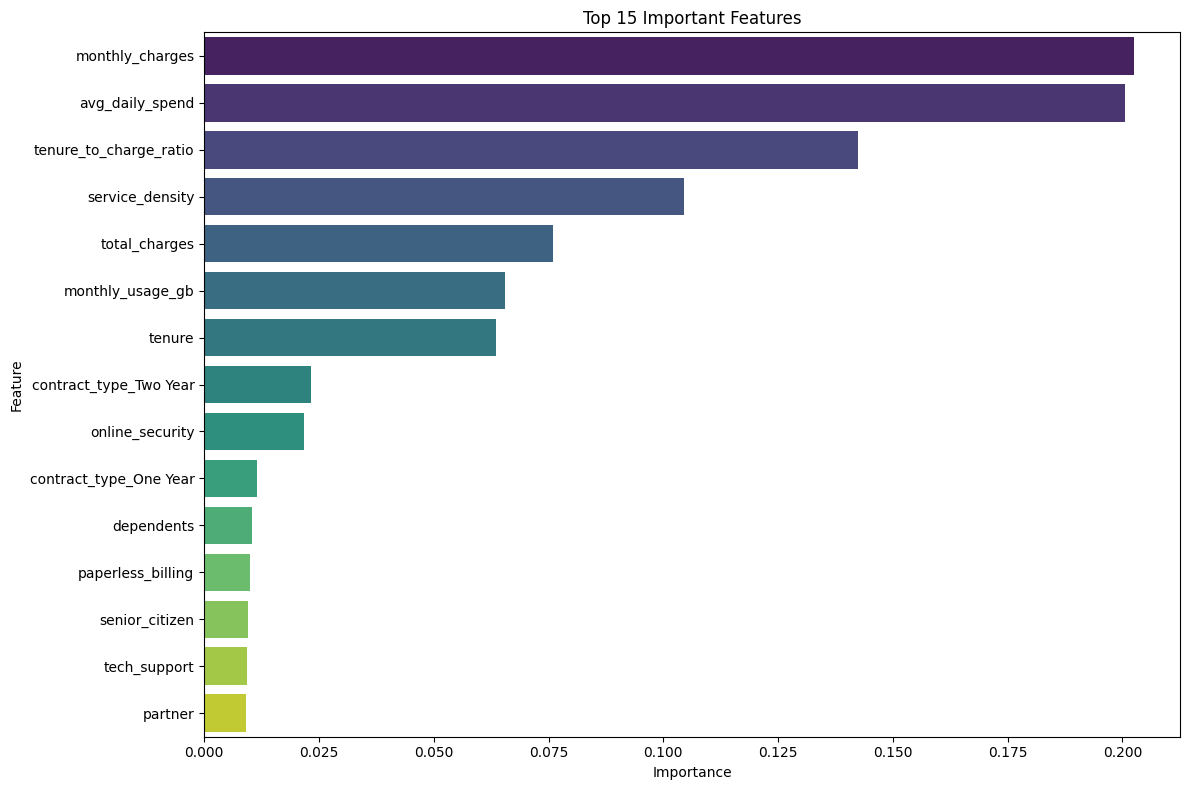

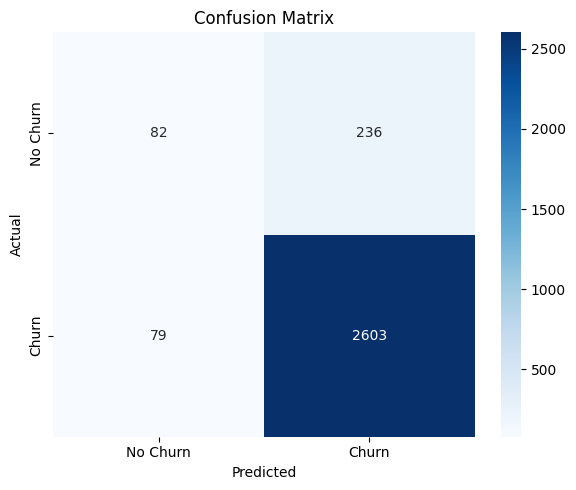

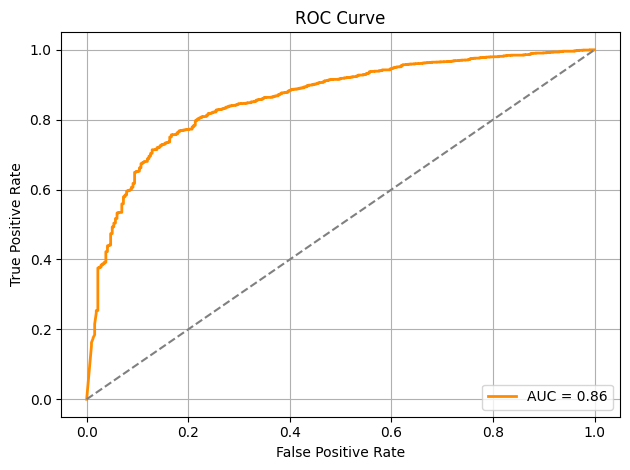

/tmp/ipython-input-8-3589881011.py:154: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, plot_type='bar')


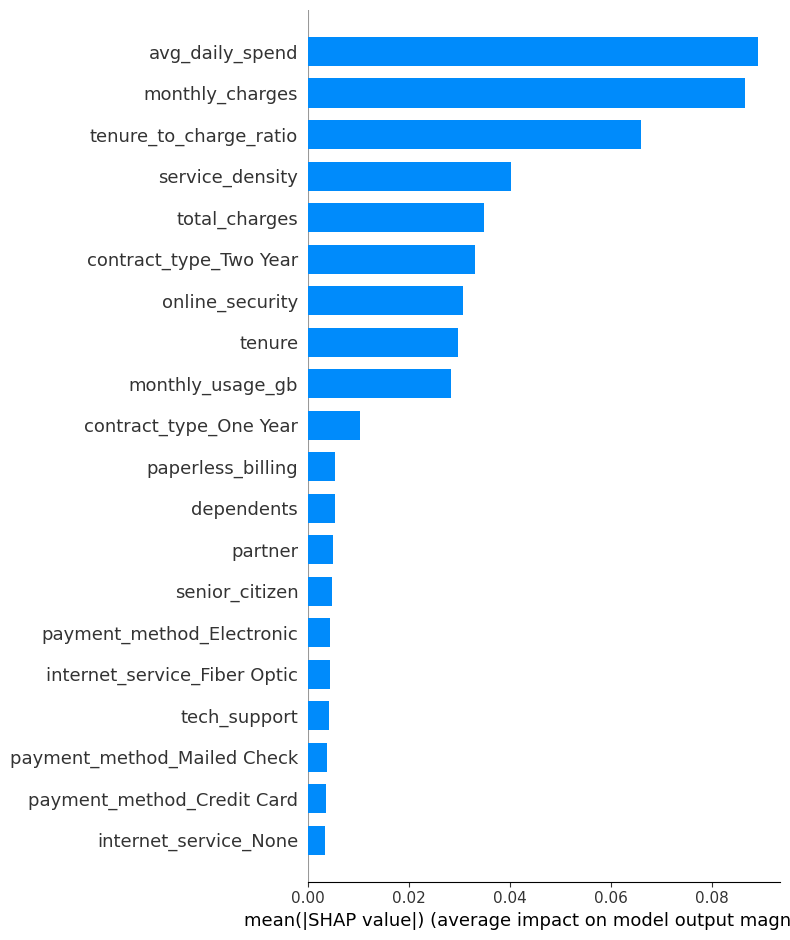

<Figure size 640x480 with 0 Axes>


Final Model Accuracy: 0.8950


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc
)

# For reproducibility
np.random.seed(42)

# Simulate customer data
n = 10000
data = {
    'tenure': np.random.randint(1, 72, n),
    'monthly_charges': np.round(np.random.uniform(20, 150, n), 2),
    'total_charges': np.random.uniform(50, 10000, n),
    'contract_type': np.random.choice(['Month-to-Month', 'One Year', 'Two Year'], n, p=[0.5, 0.3, 0.2]),
    'paperless_billing': np.random.choice([0, 1], n, p=[0.4, 0.6]),
    'payment_method': np.random.choice(['Electronic', 'Mailed Check', 'Bank Transfer', 'Credit Card'], n),
    'senior_citizen': np.random.choice([0, 1], n, p=[0.7, 0.3]),
    'dependents': np.random.choice([0, 1], n, p=[0.6, 0.4]),
    'partner': np.random.choice([0, 1], n, p=[0.55, 0.45]),
    'online_security': np.random.choice([0, 1], n, p=[0.6, 0.4]),
    'tech_support': np.random.choice([0, 1], n, p=[0.65, 0.35]),
    'internet_service': np.random.choice(['DSL', 'Fiber Optic', 'None'], n, p=[0.4, 0.4, 0.2]),
    'monthly_usage_gb': np.random.randint(50, 1000, n),
}

# Simulate churn
logits = (
    -0.02 * data['tenure'] +
    0.05 * data['monthly_charges'] -
    0.0001 * data['total_charges'] +
    np.where(data['contract_type'] == 'Month-to-Month', 0.8,
             np.where(data['contract_type'] == 'One Year', 0.2, -0.5)) +
    np.where(data['online_security'] == 1, -0.6, 0.3)
)
prob = 1 / (1 + np.exp(-logits))
data['churn'] = np.random.binomial(1, prob)

# Create DataFrame
df = pd.DataFrame(data)

# Add derived features
df['avg_daily_spend'] = df['monthly_charges'] / 30
df['tenure_to_charge_ratio'] = df['tenure'] / df['monthly_charges']
df['service_density'] = df['monthly_usage_gb'] / df['monthly_charges']

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['contract_type', 'payment_method', 'internet_service'], drop_first=True)

# Split into features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Check class distribution
print("Class distribution:")
print(y.value_counts(normalize=True), '\n')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Random Forest with cross-validation
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluate performance
best_rf = model.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Calculate and store accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", model.best_params_)
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()  # Display plot instead of saving/closing

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()  # Display plot

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()  # Display plot

# Save model to disk
joblib.dump(best_rf, 'rf_churn_model.pkl')

# SHAP feature explanations
try:
    explainer = shap.TreeExplainer(best_rf)
    shap_values = explainer.shap_values(X_test)
    plt.figure()
    shap.summary_plot(shap_values[:, :, 1], X_test, plot_type='bar')
    plt.tight_layout()
    plt.show()  # Display SHAP plot
except ImportError:
    print("SHAP not installed, skipping explanations")

# Print final accuracy confirmation
print(f"\nFinal Model Accuracy: {accuracy:.4f}")
